# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

In [1]:
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector

from sklearn import set_config

set_config(display="diagram")

import warnings
warnings.filterwarnings('ignore')

In [2]:
used_cars = pd.read_csv("/Users/erindoherty/Desktop/UC Berkeley AI ML/Practical Application 2/data/vehicles.csv")

In [3]:
used_cars.isna().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [7]:
#Business Objective: Understand what factors make a car more or less expensive to provide clear recommendations dealerships on what consumers value in a used car

In [9]:
#Business task: Identify key drivers for used car prices 

In [11]:
#Data Mining Goal: Develop a predictive model to identify the most significant variables influencing used car prices 

In [13]:
#Data Mining Task: Apply clustering, PCA, feature selection and regression techniques to quantify the impact of various attributes (e.g., odometer, manufacturer, model, year, condition) on used car prices. 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [15]:
#Examine dataset properties
used_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [17]:
#filter dataframe to isolate price values of 0 and remove 
used_cars = used_cars[used_cars['price'] > 0]

In [19]:
zero_price_rows = (used_cars['price'] == 0).sum()
print(f"Number of rows with price = 0: {zero_price_rows}")

Number of rows with price = 0: 0


In [21]:
used_cars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 393985 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            393985 non-null  int64  
 1   region        393985 non-null  object 
 2   price         393985 non-null  int64  
 3   year          392812 non-null  float64
 4   manufacturer  377800 non-null  object 
 5   model         389284 non-null  object 
 6   condition     242596 non-null  object 
 7   cylinders     233575 non-null  object 
 8   fuel          391391 non-null  object 
 9   odometer      391695 non-null  float64
 10  title_status  386251 non-null  object 
 11  transmission  392162 non-null  object 
 12  VIN           241827 non-null  object 
 13  drive         273731 non-null  object 
 14  size          111052 non-null  object 
 15  type          308053 non-null  object 
 16  paint_color   276836 non-null  object 
 17  state         393985 non-null  object 
dtypes: float6

In [23]:
#handle missing values by replacing or droping
used_cars.drop(columns='VIN', inplace=True)

categorical_to_fill = ['manufacturer', 'model', 'condition', 'cylinders', 'fuel',
                       'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color']
for col in categorical_to_fill:
    used_cars[col].fillna('Unknown', inplace=True)

used_cars['year'].fillna(used_cars['year'].median(), inplace=True)
used_cars['odometer'].fillna(used_cars['odometer'].median(), inplace=True)

In [25]:
# Look at the shape of the dataset
print(f"Dataset has {used_cars.shape[0]} rows and {used_cars.shape[1]} columns.")

Dataset has 393985 rows and 17 columns.


In [27]:
used_cars.describe()

,id,price,year,odometer
count,3.939850e+05,3.939850e+05,393985.000000,3.939850e+05
mean,7.311481e+09,8.147763e+04,2011.012051,9.866133e+04
std,4.472202e+06,1.268064e+07,9.617171,2.053184e+05
min,7.207408e+09,1.000000e+00,1900.000000,0.000000e+00
25%,7.308131e+09,7.000000e+03,2008.000000,3.825300e+04
50%,7.312626e+09,1.500000e+04,2013.000000,8.700000e+04
75%,7.315250e+09,2.759000e+04,2017.000000,1.350000e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


<Axes: >

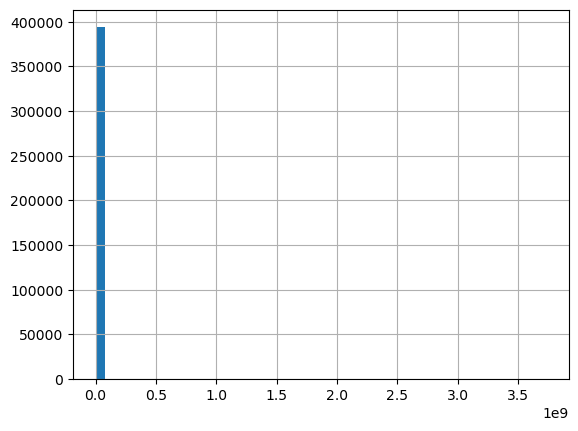

In [29]:
#use plots to examine target feature 
used_cars['price'].hist(bins=50)

In [31]:
#drop outliers under $500 as a minimum price baseline for used cars 
used_cars = used_cars[used_cars['price'] >= 500]

In [33]:
#drop outliers over $150,000 as a reasonable maximum price baseline for used cars
used_cars = used_cars[used_cars['price'] <= 150_000]

In [35]:
#Compute basic statistics for target attribute
print(used_cars['price'].describe())

count    384590.000000
mean      19284.188057
std       14842.550262
min         500.000000
25%        7800.000000
50%       15900.000000
75%       27990.000000
max      150000.000000
Name: price, dtype: float64


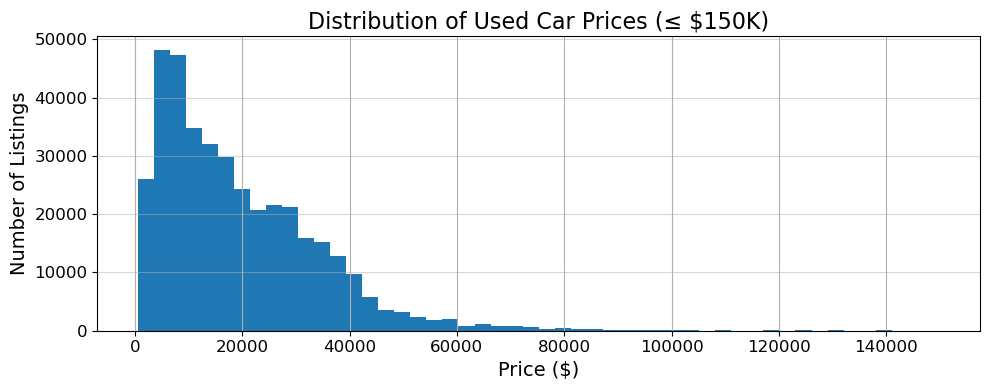

In [37]:
#repeate plot above to reexamine target feature after removing outliers
plt.figure(figsize=(10, 4)) 
used_cars['price'].hist(bins=50)

plt.title("Distribution of Used Car Prices (≤ $150K)", fontsize=16)
plt.xlabel("Price ($)", fontsize=14)
plt.ylabel("Number of Listings", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.show()

In [39]:
used_cars.nunique().sort_values(ascending=False)

id              384590
odometer         97202
model            27523
price            15078
region             404
year               112
state               51
manufacturer        43
type                14
paint_color         13
cylinders            9
condition            7
title_status         7
fuel                 6
size                 5
transmission         4
drive                4
dtype: int64

In [41]:
used_cars = used_cars.drop(columns=['id'])
used_cars.nunique().sort_values(ascending=False)                           

odometer        97202
model           27523
price           15078
region            404
year              112
state              51
manufacturer       43
type               14
paint_color        13
cylinders           9
condition           7
title_status        7
fuel                6
size                5
transmission        4
drive               4
dtype: int64

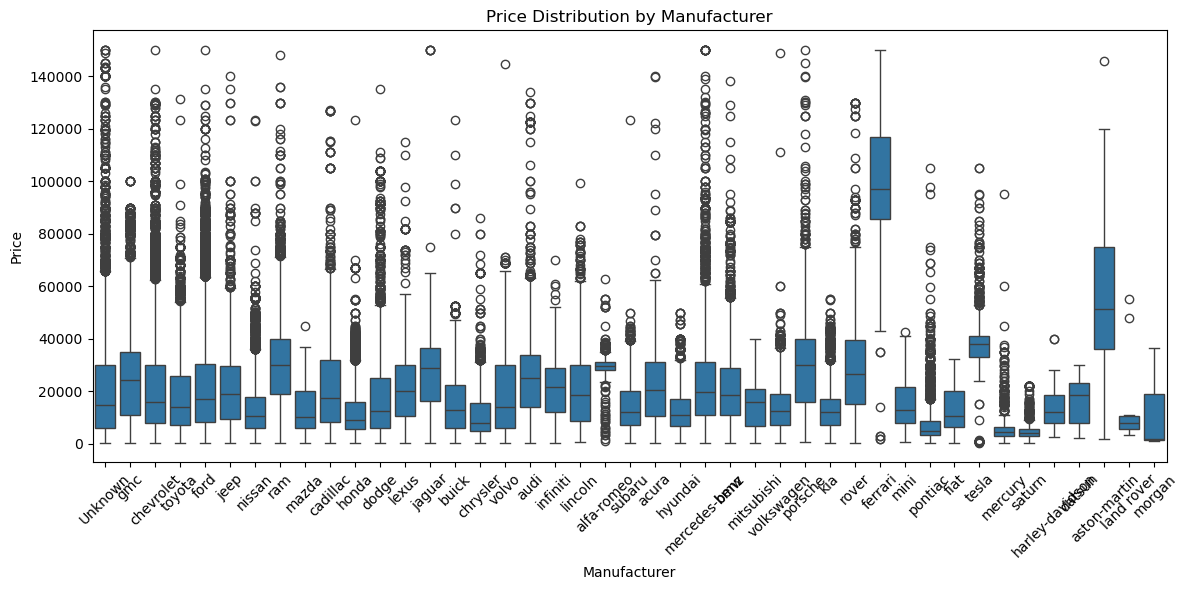

In [43]:
#Use plots like histograms, boxplots, value counts for key features against price to examine distributions and correlations
plt.figure(figsize=(12, 6))
sns.boxplot(x='manufacturer', y='price', data=used_cars)
plt.title('Price Distribution by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

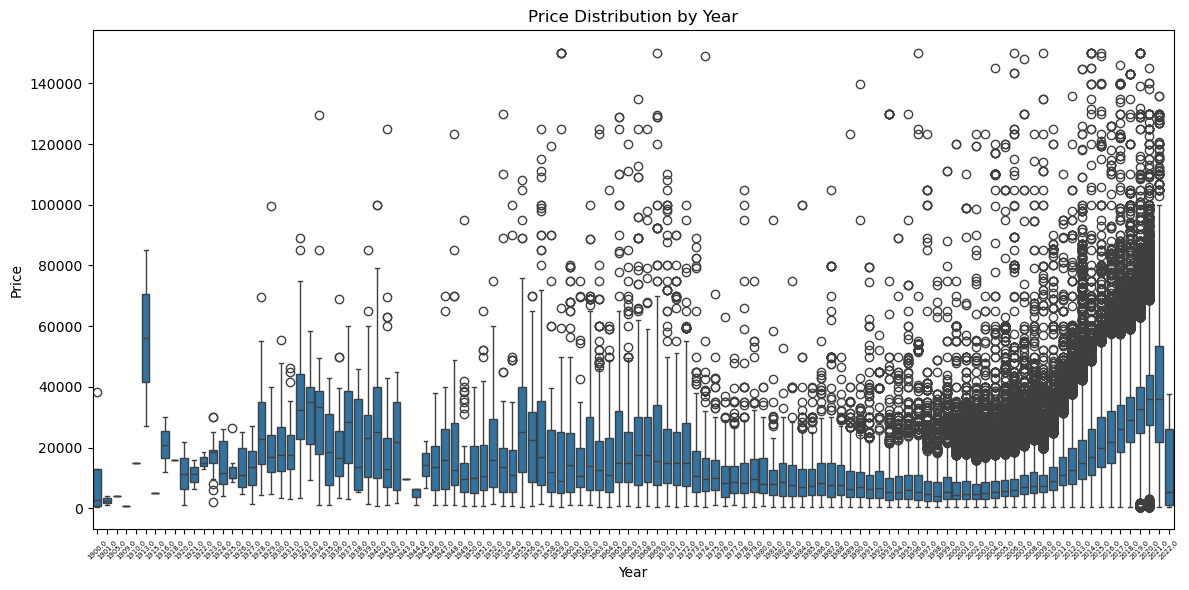

In [45]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='price', data=used_cars)
plt.title('Price Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Price')
plt.xticks(rotation=45, fontsize=5)
plt.tight_layout()
plt.show()

In [47]:
current_year = pd.Timestamp.now().year
used_cars['car_age'] = current_year - used_cars['year']
age_groups = used_cars['car_age'] <= 25

print("Cars 25 years old or newer:", age_groups.sum())
print("Cars older than 25 years:", (~age_groups).sum())

Cars 25 years old or newer: 360361
Cars older than 25 years: 24229


In [49]:
#remove data with cars older than 25 years 
current_year = pd.Timestamp.now().year
used_cars = used_cars[used_cars['year'] >= (current_year - 25)]

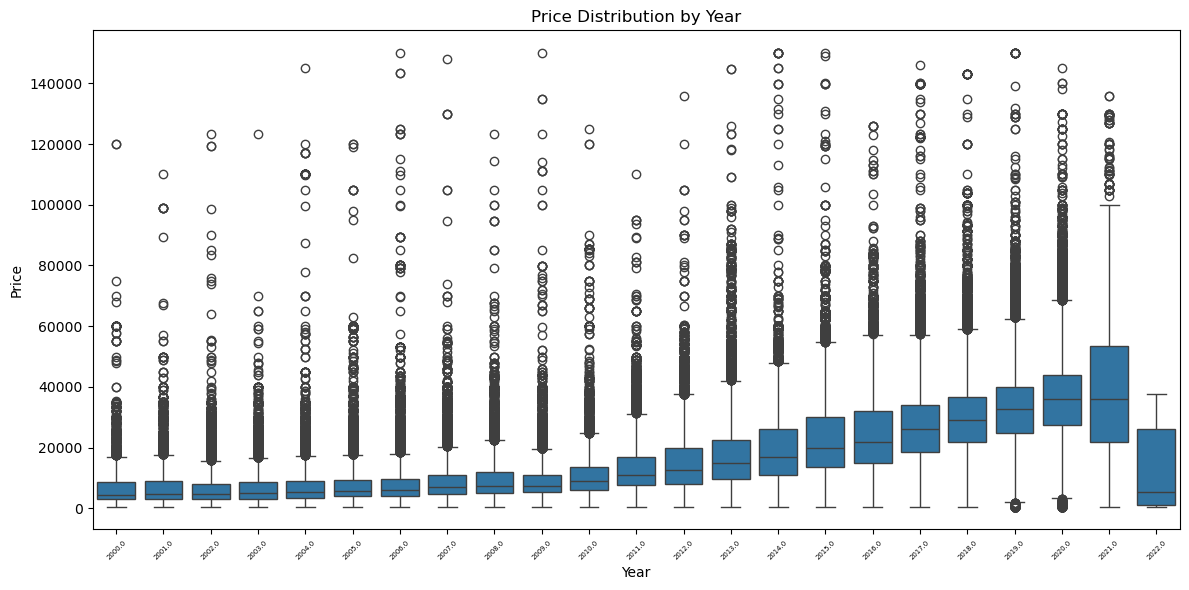

In [51]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='price', data=used_cars)
plt.title('Price Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Price')
plt.xticks(rotation=45, fontsize=5)
plt.tight_layout()
plt.show()

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [53]:
#Find and remove duplicates
duplicates = used_cars[used_cars.duplicated()]
print(f"Number of duplicate rows: {duplicates.shape[0]}")

Number of duplicate rows: 45268


In [55]:
used_cars = used_cars.drop_duplicates()

In [57]:
#optimize data types
used_cars['year'] = used_cars['year'].astype('Int64')

categorical_cols = [
    'region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
    'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state'
]
used_cars[categorical_cols] = used_cars[categorical_cols].astype('category')

In [59]:
#One-hot encode key categorical variables
categorical_cols = [
    'manufacturer', 'condition', 'cylinders', 'fuel',
    'transmission', 'drive', 'type', 'paint_color', 'title_status'
]

used_cars[categorical_cols] = used_cars[categorical_cols].astype(str)
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoded_array = ohe.fit_transform(used_cars[categorical_cols])
encoded_df = pd.DataFrame(encoded_array, columns=ohe.get_feature_names_out(categorical_cols), index=used_cars.index)
used_cars_encoded = pd.concat([used_cars.drop(columns=categorical_cols), encoded_df], axis=1)

print(used_cars_encoded.shape)
used_cars_encoded.head()

(315093, 105)


,region,price,year,model,odometer,size,state,car_age,manufacturer_acura,manufacturer_alfa-romeo,...,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow,title_status_clean,title_status_lien,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage
0,prescott,6000,2013,Unknown,87000.0,Unknown,az,12.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,fayetteville,11900,2013,Unknown,87000.0,Unknown,ar,12.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,florida keys,21000,2013,Unknown,87000.0,Unknown,fl,12.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,worcester / central MA,1500,2013,Unknown,87000.0,Unknown,ma,12.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,greensboro,4900,2013,Unknown,87000.0,Unknown,nc,12.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
#Normalize numeric features
from sklearn.preprocessing import StandardScaler

numeric_cols = used_cars.select_dtypes(include=['int64', 'float64']).columns.drop('price', errors='ignore')
scaler = StandardScaler()
scaled_array = scaler.fit_transform(used_cars[numeric_cols])
scaled_df = pd.DataFrame(scaled_array, columns=numeric_cols, index=used_cars.index)
used_cars_scaled = pd.concat([used_cars.drop(columns=numeric_cols), scaled_df], axis=1)

In [63]:
#check normalized numeric feature transformation
means = used_cars_scaled[numeric_cols].mean()
stds = used_cars_scaled[numeric_cols].std()

print("Feature Means:\n", means)
print("\nFeature Standard Deviations:\n", stds)


Feature Means:
 year       -1.698124e-14
odometer    5.863066e-18
car_age    -8.947941e-17
dtype: float64

Feature Standard Deviations:
 year        1.000002
odometer    1.000002
car_age     1.000002
dtype: float64


In [65]:
unknown_counts = (used_cars == 'Unknown').sum()
print("Number of 'Unknown' values per feature:\n")
print(unknown_counts[unknown_counts > 0].sort_values(ascending=False))

Number of 'Unknown' values per feature:

size            228792
cylinders       128953
condition       113526
drive            95147
paint_color      87191
type             63728
manufacturer     10837
title_status      5575
model             2705
fuel              2045
transmission      1514
dtype: Int64


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [67]:
#build a test set to assess model performance later

In [69]:
train = used_cars
test = used_cars
X = train.drop('price', axis = 1)
y = train['price']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)
### END SOLUTION

# Check
print(X_train.shape)
print(X_test.shape)
print(type(X_train), type(y_train))

(220565, 16)
(94528, 16)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [73]:
#set a baseline to compare model to later
baseline_train = np.ones(shape = y_train.shape)*y_train.mean()
baseline_test = np.ones(shape = y_test.shape)*y_test.mean()
mse_baseline_train = mean_squared_error(baseline_train, y_train)
mse_baseline_test = mean_squared_error(baseline_test, y_test)

# Check
print(baseline_train.shape, baseline_test.shape)
print(f'Baseline for training data: {mse_baseline_train}')
print(f'Baseline for testing data: {mse_baseline_test}')

(220565,) (94528,)
Baseline for training data: 219416283.00512856
Baseline for testing data: 217326845.41413766


In [75]:
# Examine the correlations

categorical_cols = used_cars.select_dtypes(include='object').columns

feature_price_spread = []

for col in categorical_cols:
    means = used_cars.groupby(col)['price'].mean()
    std_dev = means.std()
    feature_price_spread.append((col, std_dev))

spread_df = pd.DataFrame(feature_price_spread, columns=['Feature', 'StdDevOfMeanPrice'])

spread_df = spread_df.sort_values(by='StdDevOfMeanPrice', ascending=False)

print(spread_df)


        Feature  StdDevOfMeanPrice
0  manufacturer       16136.991668
2     cylinders       10947.664017
1     condition        9636.371493
4  title_status        7583.916718
3          fuel        7346.966844
7          type        6009.978186
5  transmission        5624.116098
6         drive        5031.393394
8   paint_color        2743.002490


In [77]:
# examine non categorical features with the categorical features to determine the highest correlations

target = 'price'

categorical_cols = used_cars.select_dtypes(include='object').columns
numeric_cols = used_cars.select_dtypes(include=['number']).columns.drop(target)

cat_feature_strength = []

for col in categorical_cols:
    means = used_cars.groupby(col)[target].mean()
    std_dev = means.std()
    cat_feature_strength.append({'Feature': col, 'Metric': 'Category StdDev', 'Score': std_dev})

cat_df = pd.DataFrame(cat_feature_strength)

num_corrs = used_cars[numeric_cols].corrwith(used_cars[target]).abs().reset_index()
num_corrs.columns = ['Feature', 'Score']
num_corrs['Metric'] = 'Correlation'

combined_importance = pd.concat([cat_df, num_corrs], ignore_index=True)
combined_importance = combined_importance.sort_values(by='Score', ascending=False)

print(combined_importance)




         Feature           Metric         Score
0   manufacturer  Category StdDev  16136.991668
2      cylinders  Category StdDev  10947.664017
1      condition  Category StdDev   9636.371493
4   title_status  Category StdDev   7583.916718
3           fuel  Category StdDev   7346.966844
7           type  Category StdDev   6009.978186
5   transmission  Category StdDev   5624.116098
6          drive  Category StdDev   5031.393394
8    paint_color  Category StdDev   2743.002490
11       car_age      Correlation      0.598727
9           year      Correlation      0.598727
10      odometer      Correlation      0.290340


In [83]:
#make sure I have the right imports
from sklearn.linear_model import LinearRegression, RidgeCV, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer


In [85]:
# build pipelines for two models, Linear Regression and Ridge pipelines 
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
])

linear_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Lasso(alpha=0.1, max_iter=10000)) 
])

In [87]:
#cross validate the two models

linear_cv_scores = cross_val_score(
    linear_pipeline, X_train, y_train,
    scoring='neg_root_mean_squared_error', cv=5
)
print(f"Linear Regression CV RMSE: {-linear_cv_scores.mean():.2f}")

Linear Regression CV RMSE: 8955.65


In [89]:
lasso_cv_scores = cross_val_score(
    lasso_pipeline, X_train, y_train,
    scoring='neg_root_mean_squared_error', cv=5
)
print(f"Lasso Regression CV RMSE: {-lasso_cv_scores.mean():.2f}")

Lasso Regression CV RMSE: 8955.72


In [92]:
#fit the model on entire training data set and predict on test data

linear_pipeline.fit(X_train, y_train)
y_pred = linear_pipeline.predict(X_test)

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [96]:
#evaluate for final performance
from sklearn.metrics import mean_absolute_error, r2_score

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Final Linear Regression Performance on Test Set:")
print(f"  RMSE: ${rmse:,.2f}")
print(f"  MAE:  ${mae:,.2f}")
print(f"  R²:    {r2:.4f}")


Final Linear Regression Performance on Test Set:
  RMSE: $8,883.73
  MAE:  $5,923.27
  R²:    0.6369


In [106]:
#nake a copy of the dataset to only keep the key features and train/split data with only priority features
priority_features = ['year', 'manufacturer', 'cylinders', 'condition', 'fuel', 'type', 'odometer', 'drive', 'transmission']

used_cars_priority = used_cars[priority_features + ['price']].copy()

X = used_cars_priority.drop('price', axis=1)
y = used_cars_priority['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

In [108]:
#build priority features pipeline
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
])

linear_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [110]:
#fit the model again on entire training data set with only priority features and predict on test data
linear_pipeline.fit(X_train, y_train)
y_pred = linear_pipeline.predict(X_test)

In [112]:
##evaluate again for final performance on model with only priority features
from sklearn.metrics import mean_absolute_error, r2_score

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Final Linear Regression Performance on Test Set:")
print(f"  RMSE: ${rmse:,.2f}")
print(f"  MAE:  ${mae:,.2f}")
print(f"  R²:    {r2:.4f}")

Final Linear Regression Performance on Test Set:
  RMSE: $8,930.04
  MAE:  $5,956.99
  R²:    0.6331


In [115]:
#further data cleaning to see if that improves the model performance. 

used_cars_filtered = used_cars[
    (used_cars['odometer'] >= 1000) &
    (used_cars['odometer'] <= 250000)
].copy()


In [117]:
from sklearn.ensemble import HistGradientBoostingRegressor


In [133]:
#repeat linear model steps above now that odometer outliers have been 
priority_features = ['year', 'manufacturer', 'cylinders', 'condition', 'fuel', 'type', 'odometer', 'drive', 'transmission']

used_cars_priority = used_cars_filtered[priority_features + ['price']].copy()

X = used_cars_priority.drop('price', axis=1)
y = used_cars_priority['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

In [135]:
#build priority features pipeline
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
])

linear_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [137]:
#fit the model again on entire training data set with only priority features and predict on test data
linear_pipeline.fit(X_train, y_train)
y_pred = linear_pipeline.predict(X_test)

In [139]:
#evaluate again for final performance on model with only priority features
from sklearn.metrics import mean_absolute_error, r2_score

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Final Linear Regression Performance on Test Set:")
print(f"  RMSE: ${rmse:,.2f}")
print(f"  MAE:  ${mae:,.2f}")
print(f"  R²:    {r2:.4f}")

Final Linear Regression Performance on Test Set:
  RMSE: $8,235.01
  MAE:  $5,536.29
  R²:    0.6770


In [154]:
#create a copy of the data and try to group data to see if that will improve model performance

used_cars_grouped = used_cars.copy()

used_cars_grouped['cylinders'] = used_cars_grouped['cylinders'].replace({
    '4 cylinders': '4',
    '6 cylinders': '6',
    '8 cylinders': '8',
    '3 cylinders': 'rare',
    '5 cylinders': 'rare',
    '10 cylinders': 'rare',
    '12 cylinders': 'rare',
    'other': 'missing_or_other',
    'Unknown': 'missing_or_other'
})

used_cars_grouped['condition'] = used_cars_grouped['condition'].replace({
    'excellent': 'excellent_or_better',
    'like new': 'excellent_or_better',
    'new': 'excellent_or_better',
    'good': 'good',
    'fair': 'needs_attention',
    'salvage': 'needs_attention',
    'Unknown': 'needs_attention'
})

used_cars_grouped['fuel'] = used_cars_grouped['fuel'].replace({
    'gas': 'gas',
    'diesel': 'alt_fuel',
    'hybrid': 'alt_fuel',
    'electric': 'alt_fuel',
    'other': 'unknown',
    'Unknown': 'unknown'
})

used_cars_grouped['type'] = used_cars_grouped['type'].replace({
    'sedan': 'sedan',
    'SUV': 'SUV',
    'pickup': 'pickup',
    'truck': 'truck',
    'hatchback': 'small_car',
    'coupe': 'small_car',
    'wagon': 'small_car',
    'convertible': 'small_car',
    'mini-van': 'van',
    'van': 'van',
    'offroad': 'other',
    'bus': 'other',
    'other': 'other',
    'Unknown': 'other'
})

used_cars_grouped['drive'] = used_cars_grouped['drive'].replace({
    'fwd': 'fwd',
    'rwd': 'rwd',
    '4wd': '4wd',
    'Unknown': 'unknown'
})

used_cars_grouped['transmission'] = used_cars_grouped['transmission'].replace({
    'automatic': 'automatic',
    'manual': 'manual',
    'other': 'unknown',
    'Unknown': 'unknown'
})


In [164]:
#repeat linear model steps above now that odometer outliers have been 
priority_features = ['year', 'manufacturer', 'cylinders', 'condition', 'fuel', 'type', 'odometer', 'drive', 'transmission']

used_cars_grouped_priority = used_cars_grouped[priority_features + ['price']].copy()

X = used_cars_grouped.drop('price', axis=1)
y = used_cars_grouped['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

In [166]:
#build priority features pipeline
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
])

linear_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [168]:
#fit the model again on entire training data set with only priority features and predict on test data
linear_pipeline.fit(X_train, y_train)
y_pred = linear_pipeline.predict(X_test)

In [170]:
#evaluate again for final performance on model with only priority features
from sklearn.metrics import mean_absolute_error, r2_score

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Final Linear Regression Performance on Test Set:")
print(f"  RMSE: ${rmse:,.2f}")
print(f"  MAE:  ${mae:,.2f}")
print(f"  R²:    {r2:.4f}")

Final Linear Regression Performance on Test Set:
  RMSE: $9,200.65
  MAE:  $6,181.88
  R²:    0.6105


In [174]:
# Since model accuracy hasn't improved much, this may be reaching the limits of a linear model. Try again with a different non-linear model
selected_features = ['year', 'manufacturer', 'cylinders', 'condition', 'fuel', 'type', 'odometer']
used_cars_model = used_cars_grouped[selected_features + ['price']].copy()

X = used_cars_model.drop(columns='price')
y = used_cars_model['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)


numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_cols)
])

hgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', HistGradientBoostingRegressor(max_iter=200, random_state=42))
])


hgb_pipeline.fit(X_train, y_train)
y_pred = hgb_pipeline.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("🔍 HistGradientBoostingRegressor Performance on Test Set:")
print(f"  RMSE: ${rmse:,.2f}")
print(f"  MAE:  ${mae:,.2f}")
print(f"  R²:    {r2:.4f}")


🔍 HistGradientBoostingRegressor Performance on Test Set:
  RMSE: $7,003.09
  MAE:  $4,233.18
  R²:    0.7743


In [190]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from scipy.stats import randint, uniform
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

param_dist = {
    'model__learning_rate': uniform(0.03, 0.1),  
    'model__max_iter': randint(80, 201),
    'model__max_leaf_nodes': randint(20, 60),
    'model__min_samples_leaf': randint(10, 60)
}

random_search = RandomizedSearchCV(
    estimator=hgb_pipeline,
    param_distributions=param_dist,
    n_iter=10,  
    scoring='r2',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=1
)

random_search.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END model__learning_rate=0.06745401188473625, model__max_iter=172, model__max_leaf_nodes=34, model__min_samples_leaf=52; total time=   5.7s
[CV] END model__learning_rate=0.06745401188473625, model__max_iter=172, model__max_leaf_nodes=34, model__min_samples_leaf=52; total time=   5.0s
[CV] END model__learning_rate=0.06745401188473625, model__max_iter=172, model__max_leaf_nodes=34, model__min_samples_leaf=52; total time=   7.4s
[CV] END model__learning_rate=0.10796910002727693, model__max_iter=100, model__max_leaf_nodes=58, model__min_samples_leaf=28; total time=   4.3s
[CV] END model__learning_rate=0.10796910002727693, model__max_iter=100, model__max_leaf_nodes=58, model__min_samples_leaf=28; total time=   4.5s
[CV] END model__learning_rate=0.10796910002727693, model__max_iter=100, model__max_leaf_nodes=58, model__min_samples_leaf=28; total time=   6.3s
[CV] END model__learning_rate=0.039997491581800285, model__max_iter=1

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['year',
                                                                                'odometer']),
                                                                              ('cat',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['manufacturer',
                                                                                'cylinders',
                                                                                'condition',
                                                                                'fuel',
                                                                                'type'])])),
                                             ('model',
                                              HistGradientBoostingRegressor(max_iter=200,
                                                                            random_state=42))...
                   param_distributions={'model__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16deec200>,
                                        'model__max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16e02fef0>,
                                        'model__max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17f2e13a0>,
                                        'model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16e02fcb0>},
                   random_state=42, scoring='r2', verbose=2)

In [192]:
#finish tuning hyperparameters and evaluate performance
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("🔍 Tuned HistGradientBoostingRegressor Performance on Test Set:")
print(f"  RMSE: ${rmse:,.2f}")
print(f"  MAE:  ${mae:,.2f}")
print(f"  R²:    {r2:.4f}")
print("\nBest Params:", random_search.best_params_)



🔍 Tuned HistGradientBoostingRegressor Performance on Test Set:
  RMSE: $6,927.92
  MAE:  $4,209.60
  R²:    0.7792

Best Params: {'model__learning_rate': 0.10219987722668247, 'model__max_iter': 109, 'model__max_leaf_nodes': 57, 'model__min_samples_leaf': 11}


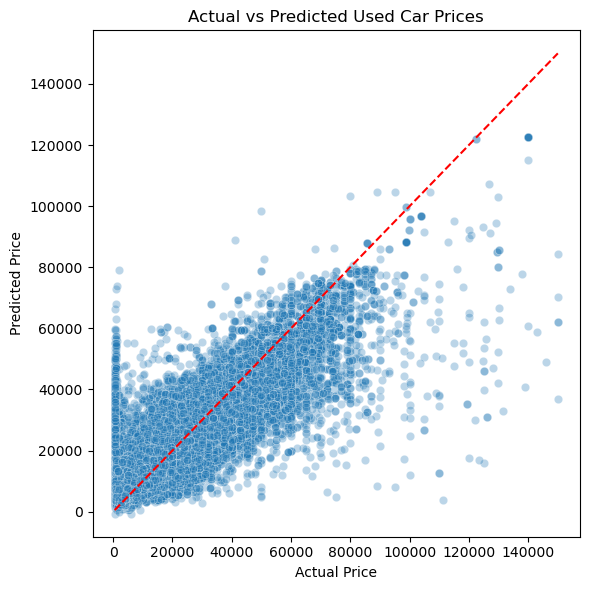

In [194]:
#not much change, latest model is pretty optimal, plot to see predictions vs. actual


plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Used Car Prices")
plt.tight_layout()
plt.show()

In [200]:
#the resulting model can explain 78% of the price variances for used cars based on attributes year, manufacturer, cylinders, condition, fuel, type, and odometer.
#there is more opportunity here to go back and process the data more given the number of unknowns and ways to investigate feature importance. However, the current model is operating within acceptable thresholds enough to deliver these initial insights to the client so they can start making inventory optimizations
#Therefore, since this model will not be customer facing or used without human review (such as in price guarantees), this model is good to use for the current business use case.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

In [220]:
#This model is great for internal insight around price optimizations, inventory recommendations, Trade-in pricing guardrails and identifying under/over-valued listings
#Key Drivers Identified
    #Vehicle age & condition have the largest price impact
    #Manufacturer, fuel type, and cylinder count influence pricing patterns significantly
    #There are other, Non-linear patterns that should be considered to best fine-tune inventory (e.g., diminishing returns after a certain age or mileage)

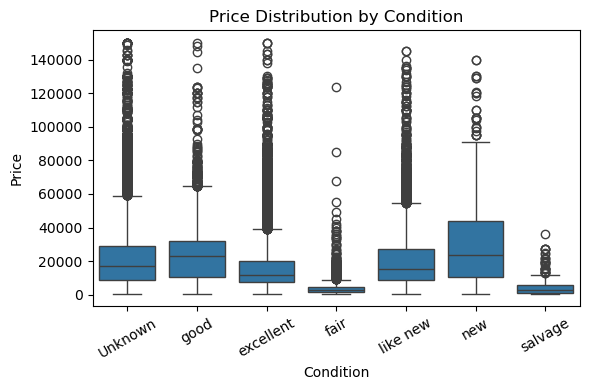

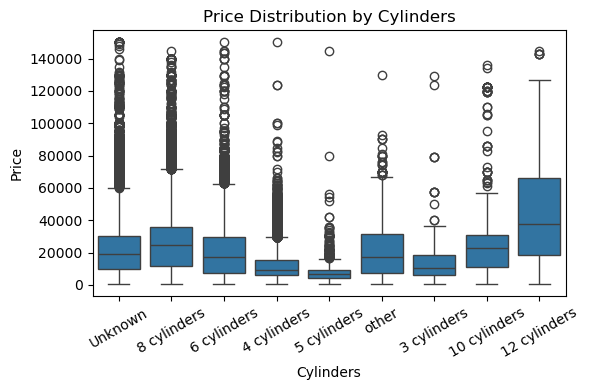

In [222]:
#for ordinal categorical features that have a natural order like 'condition', 'cylinders', 'car_age', the model can show how much price increases
ordinal_features = ['condition', 'cylinders']

for feature in ordinal_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=feature, y='price', data=used_cars)
    plt.title(f"Price Distribution by {feature.capitalize()}")
    plt.xlabel(feature.capitalize())
    plt.ylabel("Price")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

In [224]:
#an example interpretation could be:
    #keeping inventory of older/high-mileage vehicles only if: they’re in excellent condition, or if you serve a market where the number of cylinders are in higher demand (e.g. work vehicles)
    #the price difference between "good" and "excellent" condition can be incentivising enought for dealers to make repairs up to a certain point (e.g. cosmetic) in order to be able to list that inventory in the higher priced, "excellent" condition tier.

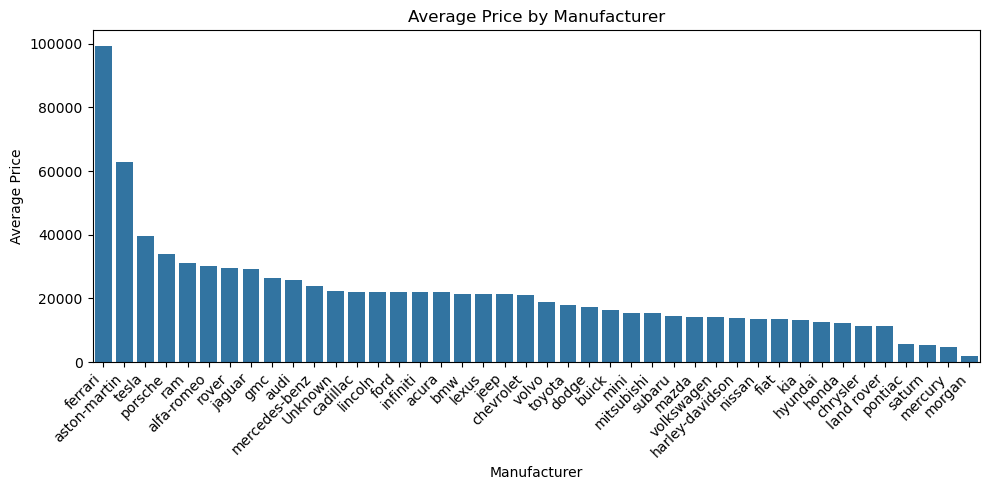

In [226]:
#for the nominal categorical features that don't have a natural order like manufacterer, the model can show how each category compares to a certain baseline for comparative purposes

plt.figure(figsize=(10, 5))
avg_price_by_mfr = used_cars.groupby('manufacturer')['price'].mean().sort_values(ascending=False)
sns.barplot(x=avg_price_by_mfr.index, y=avg_price_by_mfr.values)
plt.title("Average Price by Manufacturer")
plt.xlabel("Manufacturer")
plt.ylabel("Average Price")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

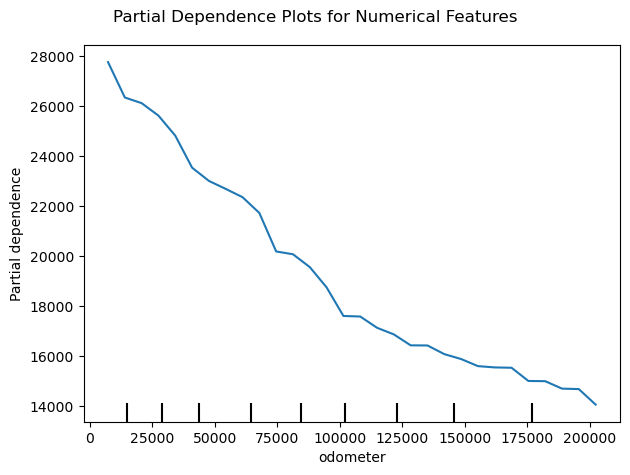

In [242]:
#for numerical features like year and odometer, the model can show how increments in these features impacts the price (e.g., each year older → $Y drop)
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    best_model, X_train, ['odometer'],
    kind='average',
    grid_resolution=30,
    feature_names=X_train.columns
)
plt.suptitle("Partial Dependence Plots for Numerical Features")
plt.tight_layout()
plt.show()

In [243]:
#an example interpretation for the odometer feature could be:
    #Prioritizing lower-mileage inventory in premium listings
    #Bundling extended warranties or maintenance incentives for high-mileage cars to maintain price competitiveness